In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#data_load
def data_load():
  songs = pd.read_csv('/content/drive/My Drive/music/songs.csv')
  transactions = pd.read_csv('/content/drive/My Drive/music/transactions.csv')
  train = pd.read_csv('/content/drive/My Drive/music/train.csv')
  test = pd.read_csv('/content/drive/My Drive/music/test.csv')
  return songs, transactions, train, test

In [0]:
def bar_chart(feature):
  male = train_merge[train_merge['gender']=='male'][feature].value_counts()
  female = train_merge[train_merge['gender']=='female'][feature].value_counts()
  dfs = pd.DataFrame([male,female])
  dfs.index = ['male','female']
  dfs.plot(kind='bar',stacked=True, figsize=(10,5))

In [0]:
def cross_tab(x1,x2):
  return pd.crosstab(x1, x2, margins=True) #genre: 남녀 비슷

In [0]:
def min_max(df, feature):
  df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

In [0]:
songs, transactions, train, test = data_load()

In [7]:
print('data_shape')
print('songs : ', songs.shape)
print('transactions : ', transactions.shape)
print('train : ', train.shape)
print('test : ', test.shape)

data_shape
songs :  (4878, 8)
transactions :  (1819855, 6)
train :  (7000, 7)
test :  (1679, 7)


In [8]:
train.head()

,user_id,city,age,reg_method,reg_date,ex_date,gender
0,13827,14,29,9,20130112,20180203,female
1,6618,13,19,4,20160313,20180106,female
2,7615,22,33,9,20060314,20170930,female
3,15535,13,48,9,20110402,20171003,female
4,17708,18,20,4,20160102,20161105,female


In [9]:
songs.head()

,song_id,length,genre,artist,composer,lyricist,language,isrc
0,5981,273554,465,330,1787,1533,3,TWC950206108
1,5767,228623,465,633,484,1057,3,TWA531398021
2,8128,257602,458,777,1916,2115,3,TWAY31508002
3,1992,199157,458,548,1011,1904,3,TWA471596001
4,2665,246015,465,671,1407,1362,3,TWK231306302


In [10]:
transactions.head()

,user_id,song_id,rec_loc,rec_screen,entry,listen
0,5,5,discover,Online playlist more,online-playlist,0
1,7,7,search,Search,song,1
2,14,14,discover,Online playlist more,song-based-playlist,0
3,22,22,my library,Local playlist more,local-library,0
4,24,24,search,Online playlist more,online-playlist,0


In [0]:
song_tran = pd.merge(transactions, songs, on = 'song_id', how='left')

In [12]:
song_tran.head()

,user_id,song_id,rec_loc,rec_screen,entry,listen,length,genre,artist,composer,lyricist,language,isrc
0,5,5,discover,Online playlist more,online-playlist,0,219150,465,55,960,520,17,JPB601402020
1,7,7,search,Search,song,1,320888,465,785,389,1078,3,TWA531530004
2,14,14,discover,Online playlist more,song-based-playlist,0,280868,465,603,1490,1449,3,TWA211650101
3,22,22,my library,Local playlist more,local-library,0,232907,444,66,570,517,31,TWA531600752
4,24,24,search,Online playlist more,online-playlist,0,296437,458,499,1384,1576,3,TWA470713001


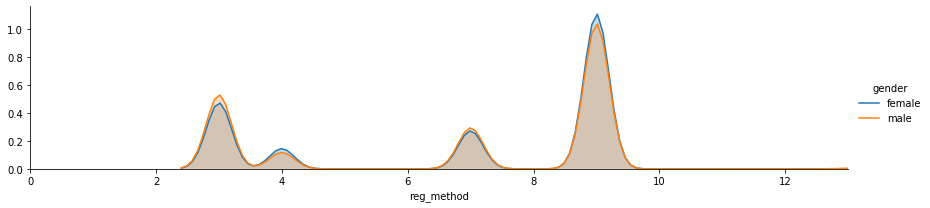

In [0]:
#두 feature 사이 비교
facet = sns.FacetGrid(train_merge, hue="gender",aspect=4)
facet.map(sns.kdeplot,'reg_method',shade= True)
facet.set(xlim=(0, train_merge['reg_method'].max()))
facet.add_legend()
 
plt.show()

In [0]:
song_tran['length'].describe()

count    1.819855e+06
mean     2.504324e+05
std      3.972178e+04
min      4.354600e+04
25%      2.235150e+05
50%      2.498350e+05
75%      2.756440e+05
max      7.584910e+05
Name: length, dtype: float64

In [0]:
b = song_tran.groupby('user_id')['composer'].agg(lambda x:x.value_counts().index[0]).reset_index()

In [22]:
b.head()

,user_id,composer
0,1,2043
1,4,1384
2,5,1384
3,7,1384
4,8,1384


train_data 만들기

In [0]:
a = song_tran.groupby('user_id')['listen'].agg({'listen_sum':'sum'}).reset_index()
train_merge = pd.merge(train, a,on='user_id' ,how='left')
l = song_tran.groupby('user_id')['length'].agg({'leng':'mean'}).reset_index()
train_merge = pd.merge(train_merge, l,on='user_id' ,how='left')
#로그 기록이 없는 사람은 음악감상을 이용하지 않은 사람 0으로 채움
train_merge['listen_sum'] = train_merge['listen_sum'].fillna(0).astype(int)
train_merge['leng'] = train_merge['leng'].fillna(0)

#loc 사용 종류
rec_loc = song_tran.groupby('user_id')['rec_loc'].agg({'rec_loc_num':'nunique'}).reset_index()
#screen 사용 종류
rec_screen = song_tran.groupby('user_id')['rec_screen'].agg({'rec_screen_num':'nunique'}).reset_index()

#rec_loc, rec_screen 붙이기
train_merge = train_merge.merge(rec_screen, on='user_id', how='left')
train_merge = train_merge.merge(rec_loc, on = 'user_id',how='left')
train_merge = train_merge.fillna(0)
#age 그룹 나누기
train_merge.loc[ train_merge['age'] <= 19, 'age'] = 0
train_merge.loc[(train_merge['age'] > 19) & (train_merge['age'] <= 40), 'age'] = 1
train_merge.loc[(train_merge['age'] > 40) & (train_merge['age'] <= 50), 'age'] = 2
train_merge.loc[ train_merge['age'] > 50, 'age'] = 3
#length 구간 나누기
train_merge.loc[ train_merge['leng'] <= 223515, 'leng'] = 0
train_merge.loc[(train_merge['leng'] > 223515) & (train_merge['leng'] <= 249835), 'leng'] = 1
train_merge.loc[(train_merge['leng'] > 249835) & (train_merge['leng'] <= 275644), 'leng'] = 2
train_merge.loc[ train_merge['leng'] > 275644, 'leng'] = 3
#등록-만료 기간 계산
train_merge['reg_date'] = pd.to_datetime(train_merge['reg_date'], format='%Y%m%d')
train_merge['ex_date'] = pd.to_datetime(train_merge['ex_date'], format='%Y%m%d')
train_merge['duration'] = (train_merge['ex_date'] - train_merge['reg_date']).dt.days
#등록, 만료 날짜 지우기
train_merge = train_merge.drop(['reg_date','ex_date'], axis=1)
#들은 횟수, duration min_max scaling
min_max(train_merge,'listen_sum')
min_max(train_merge, 'duration')

# user_id 별 청취 기록 테이블 만들기
#song_log = pd.pivot_table(song_tran, index='user_id', columns='song_id', values='listen')
#user_id에 청취 기록 로그 추가
#train_merge = train_merge.merge(song_log, on='user_id', how='left')
#청취기록 없는 사람들은 다 0 값으로
#train_merge = train_merge.fillna(0)
#노래에 대한 장르 종합
genre = pd.pivot_table(song_tran, index='user_id', columns='song_id', values='genre')
train_merge = train_merge.merge(genre, on='user_id', how='left')
train_merge = train_merge.fillna(0)
#gender mapping
train_merge.gender = train_merge.gender.map({'male': 0, 'female': 1})
#학습데이터 만들기
train_data = train_merge.drop(['user_id','gender'], axis=1)
train_label = train_merge['gender']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we loa

In [0]:
train_data.head()

,city,age,reg_method,listen_sum,leng,rec_screen_num,rec_loc_num,duration,0,2,5,6,7,11,12,14,18,19,22,24,25,26,27,28,29,32,36,37,38,39,41,43,44,45,46,48,50,52,56,58,...,9553,9555,9556,9557,9558,9559,9561,9563,9566,9567,9569,9570,9571,9572,9573,9574,9579,9581,9587,9588,9593,9599,9604,9607,9610,9611,9613,9616,9621,9622,9623,9625,9629,9633,9634,9635,9636,9637,9642,9643
0,14,1,9,0.088378,1.0,3.0,2.0,0.358905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,0,4,0.070218,1.0,8.0,5.0,0.128957,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,1,9,0.031477,2.0,5.0,4.0,0.819188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,2,9,0.100484,1.0,7.0,4.0,0.461449,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,1,4,0.016949,1.0,4.0,2.0,0.059817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_data.isnull().sum()

city          0
age           0
reg_method    0
listen_sum    0
leng          0
             ..
9635          0
9636          0
9637          0
9642          0
9643          0
Length: 4886, dtype: int64

In [0]:
#null check
train_merge.isnull().sum()

user_id       0
city          0
age           0
reg_method    0
gender        0
             ..
9635          0
9636          0
9637          0
9642          0
9643          0
Length: 4887, dtype: int64

In [0]:
#train_data check
print(train_data.shape)
print(train_label.shape)

(7000, 4885)

test_data 만들기

In [0]:
test = test.drop(['gender'], axis=1)
#각 유저의 들은 횟수 종합
a = song_tran.groupby('user_id')['listen'].agg({'listen_sum':'sum'}).reset_index()
#train에 붙이기
test_merge = pd.merge(test, a,on='user_id' ,how='left')
l = song_tran.groupby('user_id')['length'].agg({'leng':'mean'}).reset_index()
test_merge = pd.merge(test_merge, l,on='user_id' ,how='left')
#로그 기록이 없는 사람은 음악감상을 이용하지 않은 사람 0으로 채움
test_merge['listen_sum'] = test_merge['listen_sum'].fillna(0).astype(float)
#loc 사용 종류
rec_loc = song_tran.groupby('user_id')['rec_loc'].agg({'rec_loc_num':'nunique'}).reset_index()
#screen 사용 종류
rec_screen = song_tran.groupby('user_id')['rec_screen'].agg({'rec_screen_num':'nunique'}).reset_index()
#rec_loc, rec_screen 붙이기
test_merge = test_merge.merge(rec_screen, on='user_id', how='left')
test_merge = test_merge.merge(rec_loc, on = 'user_id',how='left')
test_merge = test_merge.fillna(0)
#age 그룹 나누기
test_merge.loc[ test_merge['age'] <= 19, 'age'] = 0
test_merge.loc[(test_merge['age'] > 19) & (test_merge['age'] <= 40), 'age'] = 1
test_merge.loc[(test_merge['age'] > 40) & (test_merge['age'] <= 50), 'age'] = 2
test_merge.loc[ test_merge['age'] > 50, 'age'] = 3
#음악 길이 구간 나누기
test_merge.loc[ test_merge['leng'] <= 223515, 'leng'] = 0
test_merge.loc[(test_merge['leng'] > 223515) & (test_merge['leng'] <= 249835), 'leng'] = 1
test_merge.loc[(test_merge['leng'] > 249835) & (test_merge['leng'] <= 275644), 'leng'] = 2
test_merge.loc[ test_merge['leng'] > 275644, 'leng'] = 3
#등록-만료 기간 계산
test_merge['reg_date'] = pd.to_datetime(test_merge['reg_date'], format='%Y%m%d')
test_merge['ex_date'] = pd.to_datetime(test_merge['ex_date'], format='%Y%m%d')
test_merge['duration'] = (test_merge['ex_date'] - test_merge['reg_date']).dt.days
#등록, 만료 날짜 지우기
test_merge = test_merge.drop(['reg_date','ex_date'], axis=1)
#들은 횟수, duration min_max scaling
min_max(test_merge,'listen_sum')
min_max(test_merge, 'duration')

genre = pd.pivot_table(song_tran, index='user_id', columns='song_id', values='genre')
test_merge = test_merge.merge(genre, on='user_id', how='left')
test_merge = test_merge.fillna(0)

#예측데이터 만들기
test_data = test_merge.drop(['user_id'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-pack

In [0]:
test_data.head()

,city,age,reg_method,listen_sum,leng,rec_screen_num,rec_loc_num,duration,0,2,5,6,7,11,12,14,18,19,22,24,25,26,27,28,29,32,36,37,38,39,41,43,44,45,46,48,50,52,56,58,...,9553,9555,9556,9557,9558,9559,9561,9563,9566,9567,9569,9570,9571,9572,9573,9574,9579,9581,9587,9588,9593,9599,9604,9607,9610,9611,9613,9616,9621,9622,9623,9625,9629,9633,9634,9635,9636,9637,9642,9643
0,13,1,3,0.030449,1.0,2.0,2.0,0.461264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,0,3,0.096955,2.0,6.0,4.0,0.199524,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,458.0,465.0,0.0,458.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,3,0.022436,0.0,5.0,3.0,0.212800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,0,4,0.142628,2.0,6.0,2.0,0.079849,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,0.0,458.0,465.0,0.0,458.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,1,9,0.093750,2.0,4.0,3.0,0.524074,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [0]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
model2 = SVC()
scoring = 'accuracy'
score = cross_val_score(model2, train_data, train_label, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100, 2)

[0.62       0.64428571 0.63714286 0.61142857 0.63285714 0.60571429
 0.62428571 0.62428571 0.61285714 0.58714286]


62.0

In [0]:
model = SVC()
model.fit(train_data[:5600], train_label[:5600])
print(model.score(train_data[5600:], train_label[5600:]))

0.6114285714285714


In [0]:
#교차검증
model = SVC()
scoring = 'accuracy'
score = cross_val_score(model, train_data, train_label, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100, 2)

In [0]:
model.fit(train_data, train_label)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
prediction = model.predict(test_data)

In [0]:
test['gender'] = prediction

In [0]:
test.gender = test.gender.map({1:'male', 0:'female'})

In [0]:
test.head()

,user_id,city,age,reg_method,reg_date,ex_date,gender
0,16169,13,21,3,20120118,20180604,male
1,4694,13,0,3,20150110,20171014,female
2,10654,1,18,3,20150402,20180312,female
3,9327,14,16,4,20160824,20171002,male
4,3631,22,26,9,20100927,20171225,male


In [0]:
test.to_csv('submission2.csv')

In [0]:
train_label.shape

(7000,)

In [0]:
RF = RandomForestClassifier()
scoring = 'accuracy'
score = cross_val_score(RF, train_data, train_label, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100, 2)

[0.63285714 0.61428571 0.61571429 0.61285714 0.59285714 0.58142857
 0.58571429 0.61142857 0.62142857 0.55714286]


60.26